# A Guide to Homework 5

This is a guide to some of the questions in Homework 5.  If you're having a hard time with the assignment, you can check this guide for help.

For some questions we give hints, and for others we give fully-worked examples that are very similar to the original problems.

We recommend that you not consult this guide until after you struggle a bit with a problem, because you'll learn less.  Frustration isn't helpful, but challenge is.

# 0. Preliminaries

Run the next cell to set up the guide.

In [1]:
# Run this cell, but please don't change it.

# These lines import the NumPy and datascience modules.
import numpy as np
# This way of importing the datascience module lets you write "Table" instead
# of "datascience.Table".  The "*" means "import everything in the module."
from datascience import *

# This line imports a very special module we made for this assignment.
from cats_and_boxes import *
from guide_types import *

# These lines set up visualizations.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# 1. Climate and water
If you skip ahead to question 1.13, you'll see that in the end we just want to take the `daily_temp` table and compare the readings from stations that are less than 50km from a coastline with the readings from stations that are more than 50km from a coastline.  To do that, we need to add a column to `daily_temp` with the distance-to-nearest-coast for each reading.  Everything before 1.13 is about putting together our three datasets so we can do that.

The general flow of this question is:

<img src="guide_q1_overview.jpg">

(We've rearranged and omitted some columns and sorted the rows to make the diagram more clear, so your tables might not look exactly like ours.)

**Question 1.2.** "Displaying the distribution" of a numerical array of data (or a numerical column of a table) just means displaying its histogram.  We did something very similar in [lecture](https://youtu.be/wU6eH4d-G_s?t=870).  The only difference is that the name of the table is `daily_temp` and the names of the columns are `"Tmax"` and `"Tmin"`.  Also, you should use the right units for the histogram by passing the *named argument* `unit="<whatever you want to call the units>"` to the `hist` method.

**Question 1.3 [Min/Max Average].** Break this down into three steps.

First, compute a new column (an array of numbers, one for each row in `daily_temp`) of the temperature spreads for each reading day.  Elementwise arithmetic operations (introduced in lab 3) are useful for this.

Suppose that you wanted, rather than the spread, the average of the min and max temperature for each day.  To average two numbers, you add them together and then divide that by two.  So you could say:

    min_max_average = (daily_temp.column("Tmin") + daily_temp.column("Tmax")) / 2
Here's a picture:

<img src="guide_maxminavg_apply.jpg">

The temperature spread for each day is just computed in a slightly different way.

Now, add that column to `daily_temp`, making a new table with that extra column, and give that new table a name.  We'll continue with our min-max average instead of spread.

    daily_temp_with_minmaxave = daily_temp.with_column("minmaxave", min_max_average)

Make a new code cell, write `daily_temp_with_minmaxave` (or whatever you called your table with the `"spread"` column), and run that cell.  You should see the new table with the extra column.  For your table, you can verify that the spread for each row is the max temperature for that row minus the min temperature.

Finally, use that table to make a histogram of that column.

    daily_temp_with_minmaxave.hist("minmaxave", unit = "degree Fahrenheit")

**Question 1.4.** This question is about using Python to assist you in answering a question.  So you'll write some code to display some data, and you'll also look through that data yourself.

To look at the first row of a table, you can just write the table's name in the last line of a code cell, run the cell, and look at the first row.  You could also write `stations.show(1)` to show just the first row.  Find the values in the `"Latitude"` and `"Longitude"` columns for that row.

Now, we want to look through the `coast_distance` table to find the row that roughly matches that latitude and longitude.  In the `coast_distance` table, each row is a place on Earth with a latitude (in the `"latitude"` column) and a longitude (in the `"longitude"` column).  They form an even grid over the entire planet.

Say we wanted to find the point at 37.87 degrees latitude and 122.27 degrees longitude.  (That's where Berkeley is; the actual point you want is different.)  You could write `coast_distance.show()` to show the entire `coast_distance` table and search it manually, but that would be very tedious.  Instead, try narrowing your search.

If we call `coast_distance.where(x)`, and `x` is an array of boolean values (with length equal to the number of rows in `coast_distance`), then we'll get only the rows where the corresponding element of `x` is True.  So to narrow our search, let's construct an array of boolean values that are True if the corresponding row in `coast_distance` is close (in latitude and longitude) to what we want.  First we'll put down some conditions that (roughly) define a square on the Earth's surface:

    similar_or_higher_latitude = coast_distance.column("latitude") >= 36
    similar_or_lower_latitude = coast_distance.column("latitude") <= 40
    similar_or_higher_longitude = coast_distance.column("latitude") >= 120
    similar_or_lower_longitude = coast_distance.column("latitude") >= 124
    
Now we'll combine these conditions together.  First we'll make an array of boolean values that are True whereever the longitude arrays both have a True value (defining a narrow vertical slice of the Earth) and similarly for the latitude arrays (defining a narrow belt around the Earth):

    similar_latitude = np.logical_and(similar_or_higher_latitude, similar_or_lower_latitude)
    similar_longitude = np.logical_and(similar_or_higher_longitude, similar_or_lower_longitude)

Now we'll combine those again to get an array of boolean values that are True wherever the corresponding array of `coast_distance` is inside the small square of Earth that we wanted:

    similar_coordinates = np.logical_and(similar_latitude, similar_longitude)

Now we just call `where` to look at those rows:

    nearby_places = coast_distance.where(similar_coordinates)
    nearby_places.show()

**Questions 1.5-1.11 [Shoe store example #1].** This example will illustrate one limitation of `join`: It matches values exactly, without any wiggle room.  We'll also see how to get around that.

Suppose we are an online shoe retailer, and we want to suggest shoe sizes to customers based on their height.  (People are more likely to know their height than their shoe size, and there's a pretty strong correlation between height and shoe size.)  We have the following two tables:

In [2]:
# We ask each customer his/her height and weight, and record them in this table:
customers = Table().with_columns([
        "Name", ["Sue", "Aditya", "Maxime"],
        "Height (cm)", [160, 152, 164]
    ])

# We figure out the typical shoe size for several heights.
suggested_shoe_size = Table().with_columns([
        "Height (cm)", [150, 160, 170, 180, 190],
        "Suggested shoe size", [8, 9, 10, 11, 12]
    ])
customers.show()
suggested_shoe_size.show()

Name,Height (cm)
Sue,160
Aditya,152
Maxime,164


Height (cm),Suggested shoe size
150,8
160,9
170,10
180,11
190,12


Now we want to make a table with suggested shoe sizes for each customer.  That involves combining information from both of our tables, so we should probably use `join`.  We're trying to annotate the `customers` table with some extra information from `suggested_shoe_size`, so the call to `join` should look like `customers.join...` rather than `suggested_shoe_size.join`.

What we try is this:

In [3]:
# Trying to make a table with suggested shoe sizes for Sue,
# Aditya, and Maxime:
recommendations = customers.join("Height (cm)", suggested_shoe_size)
# Note that we didn't write:
#  recommendation = suggested_shoe_size.join("Height (cm)", customers)
# That's what we'd do if we wanted to annotate each suggested shoe
# size with one customer who has that suggested shoe size.
recommendations

Height (cm),Name,Suggested shoe size
160,Sue,9


But we only get a recommendation for Sue, not for Aditya or Maxime!  What went wrong?

When we say `customers.join("Height (cm)", suggested_shoe_size)`, Python builds the resulting joined table (which we named `recommendations`) one row at a time.

First, it looks at the first row of `customers`, which is Sue.  It finds that her height (the value of `"Height (cm)"`) is 160.  Then it looks through `suggested_shoe_sizes` for a row where `"Height (cm)"` is 160.  It finds that in the 2nd row, which has suggested shoe size 9, so it makes a row in the joined table for Sue with `"Suggested shoe size"` 9.  So far, so good.

<img src="guide_customer_join_1.jpg">

Now, it looks at the second row of `customers`, which is Aditya.  His height is 152.  Looking through `suggested_shoe_size`, there's no row where the `"Height (cm)"` column is equal to 152!  So there's no match for Aditya.  His row gets discarded, and we move on to the next row in `customers`.  The same thing happens to Maxime -- no exact matching height.  So we only end up with a recommendation for Sue.

<img src="guide_customer_join_2.jpg">

What we probably wanted was to find a *reasonable* match for each customer, not an exact match.  We'd probably want to recommend a shoe size of 8 for Aditya and 9 for Maxime.  That wouldn't be perfect, but it's much better than nothing.  But the `join` method doesn't know how to do that without our help, because it always requires exact matches.

Analogously, in the homework problem, many stations have latitudes like 1.234, but the `coast_distance` table only has latitudes like 1 or 1.5.  So there wouldn't be very many *exact* matches if we said something like

    stations.join("Latitude", coast_distance, "latitude")
You can try that for yourself and see what happens.

How do we fix this?  

We would get the behavior we wanted if the *customers'* heights were rounded in the same way as the heights in the suggested shoe size table.  Those are rounded to the nearest 10, so we'll have to do the same for the customers' heights.  Here's how we'd do that:

In [4]:
def round_height(height):
    # This rounds a number to the nearest 10.
    return round(height / 10) * 10

customers_rounded = customers.with_columns([
        "Rounded Height (cm)",
        customers.apply(round_height, "Height (cm)")
    ])
customers_rounded

Name,Height (cm),Rounded Height (cm)
Sue,160,160
Aditya,152,150
Maxime,164,160


Now, we can join our two tables and get the answers we wanted!

In [5]:
# The arguments to join() here say: join with the suggested_shoe_size table,
# matching the rounded heights of rows in customers_rounded to the
# heights of rows in suggested_shoe_size.
fixed_recommendations = customers_rounded.join("Rounded Height (cm)", suggested_shoe_size, "Height (cm)")
fixed_recommendations

Rounded Height (cm),Name,Height (cm),Suggested shoe size
150,Aditya,152,8
160,Sue,160,9
160,Maxime,164,9


**Question 1.6-1.11 [Shoe store example #2].** This example will illustrate a second limitation of `join`: When we want to match things, we can only match on 1 column.  In the homework, we run into this problem when we want to match stations to locations with similar latitude *and* similar longitude.

Going back to our shoe store, suppose that we discover that people who weigh more tend to have larger feet.  We want to give different recommendations for people with different weights.  So we extend both our `customers` table and our `suggested_shoe_size` table with a new column for weight.  (We've modified the data a bit to eliminate the problem we were thinking about in example #1.  Everyone has a clear match.)

In [6]:
# We ask each customer his/her height and weight, and record
# them in this table:
customers_2 = Table().with_columns([
        "Name", ["Sue", "Aditya", "Maxime"],
        "Height (cm)", [160, 150, 160],
        "Weight (kg)", [55, 55, 70]
    ])

# We figure out the typical shoe size for several heights.
suggested_shoe_size_2 = Table().with_columns([
        "Height (cm)", [150, 160, 170, 180, 190, 150, 160, 170, 180, 190],
        "Weight (kg)", [55, 55, 55, 55, 55, 70, 70, 70, 70, 70],
        "Suggested shoe size", [8, 9, 10, 11, 12, 9, 10, 11, 12, 13]
    ])
customers_2.show()
suggested_shoe_size_2.show()

Name,Height (cm),Weight (kg)
Sue,160,55
Aditya,150,55
Maxime,160,70


Height (cm),Weight (kg),Suggested shoe size
150,55,8
160,55,9
170,55,10
180,55,11
190,55,12
150,70,9
160,70,10
170,70,11
180,70,12
190,70,13


We'd like to match Sue to shoe size 9, Aditya to shoe size 8, and Maxime to shoe size 10.  But `join` simply doesn't let us match on two columns at once like that!

In [7]:
# We want to do something like this...
# customers_2.join(["Height (cm)", "Weight (kg)"], suggested_shoe_size_2)
# ...but join just doesn't support that. :-(

If we just decide to just join on height, we don't get what we wanted.  Maxime gets matched to the suggestion for people who weigh 55 kilograms, but he weighs 70 kilograms.

In [8]:
customers_2.join("Height (cm)", suggested_shoe_size_2)

Height (cm),Name,Weight (kg),Weight (kg)_2,Suggested shoe size
150,Aditya,55,55,8
160,Sue,55,55,9
160,Maxime,70,55,9


Okay, let's fix that.  The idea is to combine the data in the two columns (height and weight) into a single column.  We'll do that for both `customers_2` and `suggested_shoe_size_2`, and then use that new column to join.

First, we'll write a function that takes two numbers and puts them together into a single *string*.  (Sound familiar?)  Then we'll apply that function to the height/weight columns in both tables.

In [9]:
def shoes_append_numbers(num1, num2):
    # This function takes two arguments, both numbers, and returns
    # the string "<num1> and <num2>".
    # So we'd like to create a string that puts " and " in
    # between the two given numbers.  Recall that adding two strings
    # with + makes a new string with both strings smashed
    # together.  But we can't add a string and a number, or
    # Python will raise an error.  Instead, we first make string
    # versions of our numbers.
    string_num1 = str(num1)
    string_num2 = str(num2)
    return string_num1 + " and " + string_num2

customers_heights_and_weights = customers_2.apply(shoes_append_numbers, ["Height (cm)", "Weight (kg)"])
customers_2.append_column("height and weight", customers_heights_and_weights)
customers_2

Name,Height (cm),Weight (kg),height and weight
Sue,160,55,160 and 55
Aditya,150,55,150 and 55
Maxime,160,70,160 and 70


Here's a picture of how `customers_2.apply(shoes_append_numbers, ["Height (cm)", "Weight (kg)"])` works:

<img src="guide_shoes_append_numbers.jpg">

In [10]:
# Now we're just doing the same thing for suggested_shoe_size_2:
suggestions_heights_and_weights = suggested_shoe_size_2.apply(shoes_append_numbers, ["Height (cm)", "Weight (kg)"])
suggested_shoe_size_2.append_column("height and weight", suggestions_heights_and_weights)
suggested_shoe_size_2

Height (cm),Weight (kg),Suggested shoe size,height and weight
150,55,8,150 and 55
160,55,9,160 and 55
170,55,10,170 and 55
180,55,11,180 and 55
190,55,12,190 and 55
150,70,9,150 and 70
160,70,10,160 and 70
170,70,11,170 and 70
180,70,12,180 and 70
190,70,13,190 and 70


Now we can join using this new amalgamated column we've created.  Notice that Maxime's "height and weight" is "160 and 70", which matches the value of "height and weight" in the row of `suggested_shoe_size_2` with suggested shoe size 10.  That's what we wanted.

In [11]:
# Now we can join using this new amalgamated column we created.
# We can omit the third argument to join, which would ordinarily
# be the name of the column in suggested_shoe_size_2 to match on,
# because it's just "height and weight" again.
recommendations_2 = customers_2.join("height and weight", suggested_shoe_size_2)
# Get rid of some redundant columns to help you see what's going on...
recommendations_2 = recommendations_2.select([0, 1, 2, 3, 6])
recommendations_2

height and weight,Name,Height (cm),Weight (kg),Suggested shoe size
150 and 55,Aditya,150,55,8
160 and 55,Sue,160,55,9
160 and 70,Maxime,160,70,10


Now Maxime gets the right suggested shoe size for her height and weight (10), and our online shoe store will thrive.

**Question 1.7.** Follow the suggestion in the problem and try examples:

In [12]:
def mysterious_function(num):
    return round(2 * num) / 2

# Add some lines like this to see what mysterious_function returns for various inputs:
print(mysterious_function(3.01))
print(mysterious_function(3.99))
# So far it looks like mysterious_function just rounds to the nearest integer.  Let's see...
print(mysterious_function(3.49))
print(mysterious_function(3.51))
print(mysterious_function(3.24))
print(mysterious_function(3.26))

3.0
4.0
3.5
3.5
3.0
3.5


**Question 1.13.** Let's look at a similar task.  We're going to put stations into three groups: close to coast (less than 50 km from a coast), sort of near a coast (50 to 250 km from a coast), and very far inland (\>250 km from a coast).  And we'll compute the average max temperature instead of the average spread.  This will let us see if coastal areas have lower average temperatures, in addition to smaller variation in temperature.

First, we'll define a function that takes a single number (intended to be a distance from coast, in kilometers) and returns a different string depending on how big the distance is:

    def coast_category(distance):
        if distance < 50:
            return "close to coast"
        elif 50 <= distance < 250:
            return "sort of near coast"
        else:
            return "very far from coast"

To answer question 1.13, you'd make a slightly different categorization function.  Instead of the strings `"close to coast"`, `"sort of near coast"`, and `"very far from coast"`, you'd want to return the boolean value `True` if the distance is bigger than 50 and `False` otherwise.

Now we'll use `apply` and our categorization function to categorize each reading in `daily_temp_with_distances`.  We'll also grab the max temperature for each day.

    max_temp_and_category = Table().with_columns([
            "max temp (°F)",
            daily_temp_with_distances.column("Tmax"),
            "coast category", 
            daily_temp_with_distances.apply(coast_category, "distance to coast (km)")
        ])

Finally, we'll group by the categories we created:

    max_by_category = max_temp_and_category.group("coast category", np.average)
    print(max_by_category)
    
...which results in:

    coast category      | max temp (°F) average
    close to coast      | 68.9502
    sort of near coast  | 71.6054
    very far from coast | 65.3718
    
It looks like maximum temperature is lowest on average for places very far from the coast.  That probably reflects the large inland landmasses in North America and Asia, which are generally very cold.  But the relationship isn't simple -- the highest average temperature is in the middle category.

**Discussion question**: Does our analysis suggest that being very far from a coast is associated with low temperatures?  Does it suggest that being very far from a coast *causes* low temperatures?

# 2. Cats and boxes
This question is intended to help you think about abstract representations of real-world objects.  Rather than go through the questions, we'll work some other examples.

**Example Question 2.5.**

<img src="guide_box01.jpg">

The only thing in this scene is a box, and there's nothing inside it.  So the right representation for this one is just `Box()`.  If we had to assign that the name `box_25`, as in the homework problems, we might write:

In [13]:
box_25 = Box()
box_25

Box()

**Example Question 2.6.**

<img src="guide_cat01.jpg">

In this scene, there is one box, so we know that our expression should look something like `Box(...)`, except with the contents of the box instead of the `...`.

Inside that box, there are 5 cats.  (Count heads.)  Each cat should be represented by a Cat object inside the Box.  To make a Cat object, we just write `Cat()`.  So the right representation is:

In [14]:
box_26 = Box(Cat(), Cat(), Cat(), Cat(), Cat())
box_26

Box(Cat(), Cat(), Cat(), Cat(), Cat())

It's worth noting that we're supposed to pass arguments to `Box` in the order in which things appear in the box, *left to right*.  In this case, since all the cats are represented in the same way (they're all just `Cat()`), the order doesn't matter, and we don't actually have to figure out how the cats are arranged, which isn't all that well-defined for this scene.

**Example Question 2.7.**

We were surprised to learn after designing this homework assignment that some pictures on the Internet could not be represented with our `Box` and `Cat` types alone.  To fix this (and to give you more examples without just answering the homework questions), we have introduced two new types for this guide:
* Kitten: A Kitten object represents a kitten.  As with Cat objects, we can construct a Kitten by calling the `Kitten` function with no arguments.  That is, the value of `Kitten()` is a Kitten object.
* Dog: A Dog is similar to a Cat, but unlike Cats and Kittens, it has a specific breed.  So the function `Dog` takes a single argument, a *string* that is the breed of the Dog to be created, and returns a Dog with that breed.

For example,

In [15]:
Dog("Shiba Inu")

Dog("Shiba Inu")

is a Dog object that represents a Shiba Inu (a breed of dog).

In [16]:
[Kitten(), Kitten()]

[Kitten(), Kitten()]

is a list of two Kittens.

In [17]:
Table().with_columns([
        "animal", [Kitten(), Cat()],
        "name",   ["Susy",   "Quincy"]
    ])

animal,name
Kitten(),Susy
Cat(),Quincy


is a table representing two animals, the first a kitten named Susy, and the second a cat named Quincy.  Note that the animals' names are not part of the Kitten or Cat objects; we've just used a two-column table to associate a name with each animal.

Now, let's think about how to represent the following picture:

<img src="guide_dogcat01.jpg">

In the picture, everything is inside one box.  So our expression for the scene should look like `Box(...)`, with some stuff instead of `...`.

There's a dog to the far left, and it appears to be a Border Collie.  So the first argument to `Box` should be `Dog("Border Collie")`.  To the right of that is a mother cat, so the second argument to `Box` should be `Cat()`.  To the right of that is 4 kittens, so the last 4 arguments to `Box` should all be `Kitten()`.  So we get the expression:

In [18]:
box_27 = Box(Dog("Border Collie"), Cat(), Kitten(), Kitten(), Kitten(), Kitten())
box_27

Box(Dog("Border Collie"), Cat(), Kitten(), Kitten(), Kitten(), Kitten())

# 3. Warplanes

This problem is very similar to the example from [lecture on 2/19](https://data-8.appspot.com/sp16/unit?unit=4&lesson=32).  However, we're asking you to write the code in slightly different ways than you saw in lecture.  There's often more than one way to write code to do something, and it's good to see many different approaches.

For the guide, we're going to go through a very similar problem.  *Please understand: The statistical setup behind this problem is different from the setup of the Warplane problem, but the code is almost identical.*  So pay attention to the differences.

In the fantasy role-playing game Dungeons & Dragons, a player performs actions by rolling a 20-sided die, adding a "modifier" number to the roll that depends on her character's competency with that action, and comparing the total to a threshold for success.  For example, suppose Alice's character, a barbarian warrior named Roga, is trying to knock down a heavy door.  She rolls a 20-sided die, adds a modifier of 11 to the result (because her character is good at knocking down doors), and succeeds if the total is greater than 15.

Suppose we don't know that Roga has a modifier of 11 for this action.  Instead, we observe the total (that is, the die roll plus the modifier of 11) from each of 7 of her attempts to knock down doors.  We do know that she rolls 20-sided dice and adds her modifier to produce each of these totals.  We would like to estimate her modifier from these 7 numbers.

**Question 3.1 [D&D version].** Let's simulate a dataset of observations that we might see.  A roll of a 20-sided die is a number chosen uniformly from {1, 2, 3, 4, ..., 20}.  So a roll of a 20-sided die *plus 11* is a number chosen uniformly from {12, 13, 14, 15, ..., 31}.  So our `simulate_observations` function will return an array of 7 numbers chosen according to that distribution.

In [19]:
# Roga's true modifier
MODIFIER = 11
# The number of attempts we observe, from which we want to guess
# the value of MODIFIER.
num_observations = 7

def simulate_observations():
    # If we call np.random.randint(x, y, z), we get an array of z
    # elements, each a random number chosen uniformly from
    # {x, x+1, x+2, ..., y-1}.  So all we have to do is:
    return np.random.randint(1 + MODIFIER, 20 + MODIFIER + 1, num_observations)

# Now we just call our function once to generate observations.
observations = simulate_observations()
observations

array([13, 28, 31, 19, 30, 30, 20])

**Question 3.2 [D&D version].** Now we're going to draw a histogram to display the distribution of rolls we might see.  The steps are explained in comments in the code.

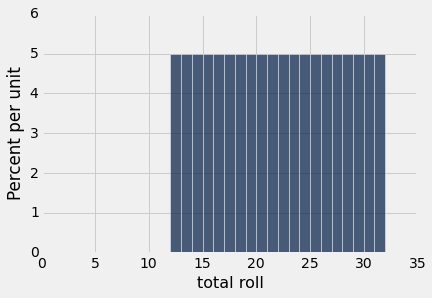

In [20]:
# First we'll make a table of the rolls.  Each roll is
# equally likely, so a histogram of this table is the same
# as a histogram of the roll distribution.
total_rolls = Table().with_column("total roll", np.arange(1+MODIFIER, 20 + MODIFIER + 1))
# To capture all the data and have one roll per bin, the bins for
# the histogram need to be at least 12-13, 13-14, 14-15, ..., 31-32.
# To show that the rolls 1, 2, 3, ..., 11 are impossible, we're
# choosing to start the bins at 1 rather than 12.
# That means we want np.arange(1, 33, 1).  You can verify that
# that's the same as np.arange(1, 20+MODIFIER+2, 1).
roll_bins = np.arange(1, 20+MODIFIER+2, 1)
# Now we just make the histogram:
total_rolls.hist(bins=roll_bins)

**Questions 3.3 [D&D version].** Now let's try to estimate the modifier.  One straightforward (but clearly suboptimal) way to do that is to find the *smallest* total roll, since the smallest roll on a 20-sided die is 1, which is roughly 0.  Using that method, we'll estimate `MODIFIER` from `observations`.

Again, note that the problem we're going over in this guide is different from that in the homework.  In the homework, it made more sense to use just the maximum observation.  In this setup, the minimum is a kinda-reasonable estimator.

In [21]:
min_estimate = min(observations)
min_estimate

13

**Question 3.4 [D&D version].** Now we'll write a function that computes a different, more complicated estimate of the modifier.  We'll take the average total roll and subtract 10, since that's roughly the average roll of a 20-sided die.  We'll call it `mean_based_modifier_estimator`.

In [22]:
def mean_based_modifier_estimator(nums):
    return np.average(nums) - 10
mean_based_modifier_estimator(np.array([11, 13, 14, 22])) # Should be (11+13+14+22)/4 - 10 = 5

5.0

Notice that this estimator is also based on the mean of the sample, like the mean-based estimator in the homework.  But in the Warplanes problem, it made sense to multiply the mean by 2.  In this case, it makes sense to subtract 10.

**Question 3.5 [D&D version].** Let's see whether these two estimation strategies are different.  They are in fact different, so hopefully the code below will display a difference:

In [23]:
print("min(observations) is " + str(min(observations)))
print("mean_based_modifier_estimator(observations) is " + str(mean_based_modifier_estimator(observations)))

min(observations) is 13
mean_based_modifier_estimator(observations) is 14.4285714286


The fact that they're different on this one example is enough to show that they're different.  We could also observe that if the lowest total roll we observe is 11, the min estimate will always be 11, but the mean-based estimate will depend on the values of the other rolls we observe.

**Question 3.6 [D&D version].** We pretty much did this above, but let's compute the mean-based estimator on `observations`.

In [24]:
mean_based_estimate = mean_based_modifier_estimator(observations)
mean_based_estimate

14.428571428571427

**Question 3.7 [D&D version].** Now we want to know how well our two estimators work.  To do that, we'll imagine what *could have happened* when we got our observations.  Concretely, that means we'll generate new sets of observations 1000 times (that is, 1000 times, we'll simulate 7 total rolls).  Each time, we'll use both estimators to compute estimates of the modifier for each simulated observation set.  In the next question, we'll display the distribution of those estimates.  That will show us how often each estimator does how well.  

Now, how does the code work?  Well, let's start by making an empty table of estimates.  There should be two columns, one for the min estimates and one for the mean-based estimates.

    estimates = Table(["min_estimate", "mean_based_modifier_estimate"])

Now, we know we want to repeat something 1000 times.  That's a job for a `for` loop.  To do something 1000 times, use an array of 1000 things, like `np.arange(0, 1000, 1)`.  `range(1000)` is basically shorthand for that.

    estimates = Table(["min_estimate", "mean_based_modifier_estimate"])
    for i in range(1000):
        ...

The lines under the `for` loop (and there can be as many as we want) will be done 1000 times.  Each time `i` will have a new value from `range(1000)`, but we don't really care about that in this case.

Each of the 1000 times, we first want to generate a new observation set.  We can use our function `simulate_observations` to do that.  We'll save the observation set by giving it the name `new_observations`.  Each time through the loop, `new_observations` will get assigned to a new observation set, and the previous one will be lost in the ether.

    estimates = Table(["min_estimate", "mean_based_modifier_estimate"])
    for i in range(1000):
        new_observations = simulate_observations()
        ...

For each observation set, we want to compute the min estimate and the mean-based estimate.  We can do that just like before, calling the built-in function `min` and the function we defined, `mean_based_modifier_estimator`.

    estimates = Table(["min_estimate", "mean_based_modifier_estimate"])
    for i in range(1000):
        new_observations = simulate_observations()
        new_min_estimate = min(new_observations)
        new_mean_based_modifier_estimate = mean_based_modifier_estimator(new_observations)
        ...

Finally, we want to add a new row with these two estimates to our table `estimates`.  One way to do that is with the Table method `append`, which takes a row (a list of values, one for each column in the table) and adds it to the table.

In [25]:
estimates = Table(["min_estimate", "mean_based_modifier_estimate"])
for i in range(1000):
    new_observations = simulate_observations()
    new_min_estimate = min(new_observations)
    new_mean_based_modifier_estimate = mean_based_modifier_estimator(new_observations)
    new_row = [new_min_estimate, new_mean_based_modifier_estimate]
    estimates.append(new_row)

estimates

min_estimate,mean_based_modifier_estimate
15,11.2857
13,10
12,8.57143
13,11.5714
12,10.1429
14,12
15,8.85714
12,11.5714
12,10.2857
13,9.57143


Here's a histogram of those estimates:

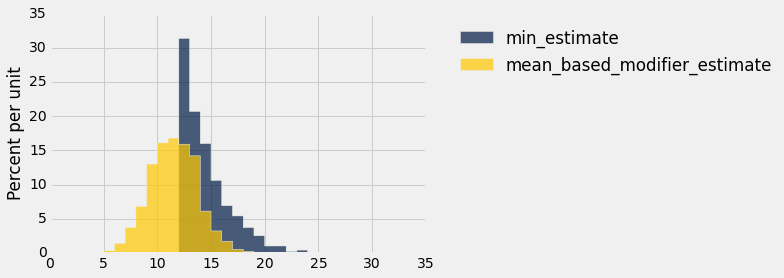

In [26]:
# Just run this cell.
estimates.hist(bins=np.arange(0, 35, 1))

**Question 3.8 [D&D version].** What do the blue and yellow histograms represent?

The blue histogram is the *empirical distribution* of estimates of the modifier using our min-based estimator.  The yellow histogram is the empirical distribution of estimates of the modifier using our mean-based estimator.

**Question 3.9 [D&D version].** Why do the `min`-based estimates bottom out at 12, while some of the `mean`-based estimates are smaller than that?

The smallest roll we can get on a 20-sided die is 1, so the smallest total roll is `1 + MODIFIER`, or 12.  It's impossible for the `min` to be smaller than that.

On the other hand, if the mean of the 7 roll totals is less than 22, then the mean-based estimate will be less than 12.  It's totally possible for the mean of 7 roll totals to be less than 22.  Our 7 rolls could be, for example, 11, 1, 4, 7, 7, 15, and 2.  That would give us total rolls of 22, 12, 15, 18, 18, 26, and 13, an average total roll of ~17.71, and a mean-based estimate of ~7.71.